<a href="https://colab.research.google.com/github/alucatto/AmP-vib-TransfEntrada/blob/main/Transforma%C3%A7%C3%A3o_de_dados_de_entrada_(tac_em_sen).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bibliotecas

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os
import time

In [ ]:
import math

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Funções 

##### Pegar os arquivos dentro dos diretórios

In [ ]:
#    For the given path, get the List of all files in the directory tree 
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

###### Auxiliar 

In [ ]:
def podando_negative_frequencies(n):    
    return n[:int(np.shape(n)[0]/2)]

#### Processando os sinais


###### Definindo dicionários com pastas de leituras



In [ ]:
'''pastas_de_arquivos = { 'normal': 0.0,
                       'imbalance':0.1,
                       'horizontal-misalignment':0.2,
                      'overhang':0.3,
                      'underhang':0.4,
                      'vertical-misalignment':0.5
                    }

In [ ]:
pastas_de_arquivos = {'Baseline': 0.0,
                      'Desbalanc1LA': 0.1,
                      'Desbalanc2LOA': 0.2,
                      'DesalinhHorizLOA': 0.3}

###### Laço por todos os arquivos

In [ ]:
'''listas_de_arquivos = []
for subfolder in pastas_de_arquivos:
    lista = getListOfFiles('C:\\Users\\Murilo\\Desktop\\Mestrado\\PSI\\Trabalho FInal/'+subfolder+'/')
    listas_de_arquivos.append([[subfolder],lista])
    

In [ ]:
listas_de_arquivos = []
for subfolder in pastas_de_arquivos:
    lista = getListOfFiles('/content/drive/My Drive/Dados coletados/'+subfolder)
    listas_de_arquivos.append([[subfolder],lista])
    

## Leitura dos arquivos

In [ ]:
dados1 = np.genfromtxt ('/content/drive/My Drive/Dados coletados/Baseline/10Hz/Normal_10Hz_001.lvm', 
                       delimiter='\t', skip_header=24, encoding = "ISO-8859-1")
#dados2 = np.genfromtxt ('/content/drive/My Drive/Dados coletados/Baseline/20Hz/Normal_20Hz_001.lvm', 
                       #delimiter='\t', skip_header=24, encoding = "ISO-8859-1")

## Montar tabela

Somando o tempo do segundo ao tempo do primeiro, para dar sensação de continuação do tempo

In [ ]:
for i in range(0,dados2.shape[0]-1):
  dados2[i,1]=dados2[i,1]+dados1[35734-1,1]

Concatenação das duas planilhas com a continuação do tempo já ajustado:

O número 35734 no final do dados1 é o índice que está sincronizando a última borda de subida do primeiro conjunto de dados com o início do segundo

In [ ]:
tabela=np.concatenate((dados1[0:35734], dados2), axis=0)

## Detecção de borda de subida e conversão em rotação

Cria um array com os índices das bordas de subida

In [ ]:
subida=np.flatnonzero((dados1[:-1,2] < 0.3) & (dados1[1:,2] > 0.3))+1
print(subida)

[  605  1211  1817  2423  3028  3634  4240  4846  5451  6057  6662  7268
  7873  8479  9083  9687 10292 10898 11503 12107 12712 13317 13922 14528
 15134 15739 16345 16951 17557 18163 18771 19377 19983 20590 21197 21803
 22409 23015 23621 24227 24832 25438 26044 26650 27256 27862 28468 29075
 29681 30286 30892 31498 32103 32709 33315 33919 34524 35129 35734]


Cálculo da rotação a partir das detecções de borda de subida

In [ ]:
print(dados1.shape)

(35999, 11)


In [ ]:
#rotacao=np.zeros(subida[subida.shape[0]-1])
rotacao=np.zeros(subida[subida.shape[0]-1]+1)

senoide=np.zeros(dados1.shape[0])

#primeiro período
for i in range (0,subida[0]):
  rotacao[i]=1/(dados1[subida[0],1]-dados1[0,1])
  senoide[i]=math.sin(2*3.1415*rotacao[i]*i)

#demais períodos
for i in range (1,subida.shape[0]):
  for j in range (subida[i-1],subida[i]):
    rotacao[j]=1/(dados1[subida[i],1]-dados1[subida[i-1],1])
    senoide[j]=math.sin(2*3.1415*rotacao[j]*j)

#arrumando ultimos pontos (estavam com nan)
for i in range(35128,subida[subida.shape[0]-1]+1): #35128 é o último valor certo
  rotacao[i]=rotacao[35128-1]
  senoide[i]=math.sin(2*3.1415*rotacao[i]*i)

print(rotacao)

[9.91738816 9.91738816 9.91738816 ... 9.91738816 9.91738816 9.91738816]


Gráfico para testes diversos. Ignorar.

In [ ]:
print(rotacao.shape)

(35735,)


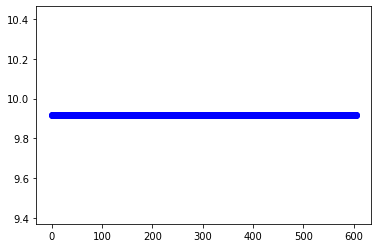

In [ ]:
#plt.plot(rotacao[subida[subida.shape[0]-2]:],'bo')
plt.plot(rotacao[35129:],'bo')
#plt.plot(tabela[subida[subida.shape[0]-2]:subida[subida.shape[0]-1],2])

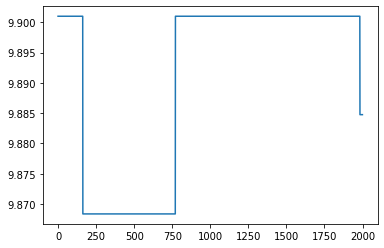

In [ ]:
plt.plot(rotacao[18000:20000])

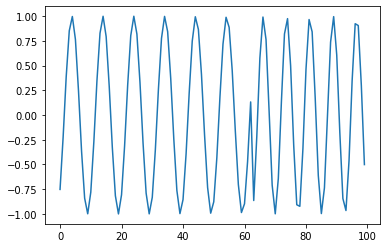

In [ ]:
plt.plot(senoide[18100:18200])

In [ ]:
rotacao.shape

(71659,)

In [ ]:
tabela.shape

(71733, 11)

Concatenar rotação senoidal na tabela de dados

In [ ]:
tabela2 = dados1[:14500]

In [ ]:
print(tabela2)

[[ 1.0000000e+00  1.6700000e-04  1.0000000e+00 ...  4.9530000e-02
   1.7883000e-02  2.1431000e-02]
 [ 2.0000000e+00  3.3300000e-04  1.0000000e+00 ...  5.2846000e-02
   1.3569000e-02  1.1224000e-02]
 [ 3.0000000e+00  5.0000000e-04  1.0000000e+00 ...  2.5712000e-02
  -1.8239000e-02  3.0980000e-03]
 ...
 [ 3.5923000e+04  1.1942834e+01  0.0000000e+00 ... -3.8771500e-01
  -2.4795000e-02 -2.0429300e-01]
 [ 3.5924000e+04  1.1943000e+01  0.0000000e+00 ... -2.8982000e-01
  -9.4705000e-02 -2.2040500e-01]
 [ 3.5925000e+04            nan  1.0000000e+00 ...            nan
             nan            nan]]


In [ ]:
tabela2.shape

(14500, 11)

In [ ]:
tabela3 = np.column_stack((tabela2, senoide[:14500]))

In [ ]:
print(tabela3)

[[ 1.00000000e+00  1.67000000e-04  1.00000000e+00 ...  1.78830000e-02
   2.14310000e-02  0.00000000e+00]
 [ 2.00000000e+00  3.33000000e-04  1.00000000e+00 ...  1.35690000e-02
   1.12240000e-02 -4.97663822e-01]
 [ 3.00000000e+00  5.00000000e-04  1.00000000e+00 ... -1.82390000e-02
   3.09800000e-03 -8.63317340e-01]
 ...
 [ 1.44980000e+04  2.41633300e+00  0.00000000e+00 ...  9.52690000e-02
  -1.83120000e-02  4.80311097e-01]
 [ 1.44990000e+04  2.41650000e+00  0.00000000e+00 ...  8.00920000e-02
  -2.91070000e-02  9.02242432e-01]
 [ 1.45000000e+04  2.41666700e+00  0.00000000e+00 ...  5.21940000e-02
  -2.31860000e-02  9.84186041e-01]]


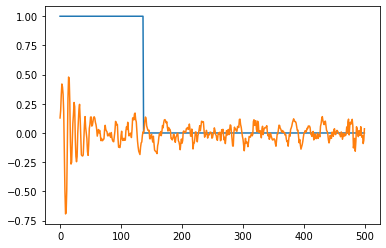

In [ ]:
plt.plot(tabela3[14000:,2])
plt.plot(tabela3[14000:,6])
#plt.plot(tabela3[14200:,11])

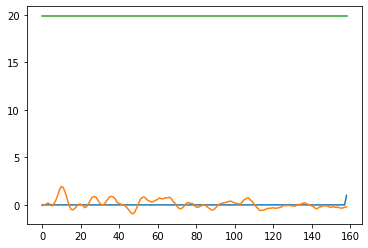

In [ ]:
plt.plot(tabela3[71500:,2])
plt.plot(tabela3[71500:,3])
plt.plot(tabela3[71500:,11])

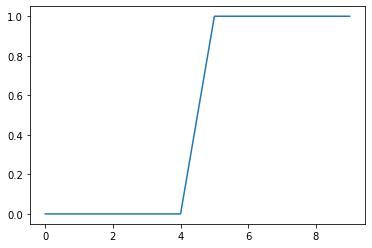

In [ ]:
plt.plot(tabela[600:610,2])

## Salvar os dados

In [ ]:
np.savetxt('/content/drive/My Drive/Dados concatenados/sen10Hz_001.csv',tabela3,
               delimiter=',')